In [11]:
!pip install matplotlib seaborn scikit-learn numpy==1.26 pandas pillow transformers  torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 534.5 kB/s eta 0:00:0000:0100:02
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.1
    Uninstalling numpy-2.2.1:
      Successfully uninstalled numpy-2.2.1


In [1]:

import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
rs = RandomState(MT19937(SeedSequence(123456789)))
import math
import pandas as pd
from turtle import title
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from glob import glob
import random
from datetime import datetime
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import os
import torch

/Users/e29154/icce-tutorial-2025/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") 
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [3]:
labels = ['bedroom', 'office', 'bathroom', 'basement', 'bookstore', 'dining_room', 'classroom', 'living_room', 'cafe', 'kitchen']

### Show example RGB image and depth image


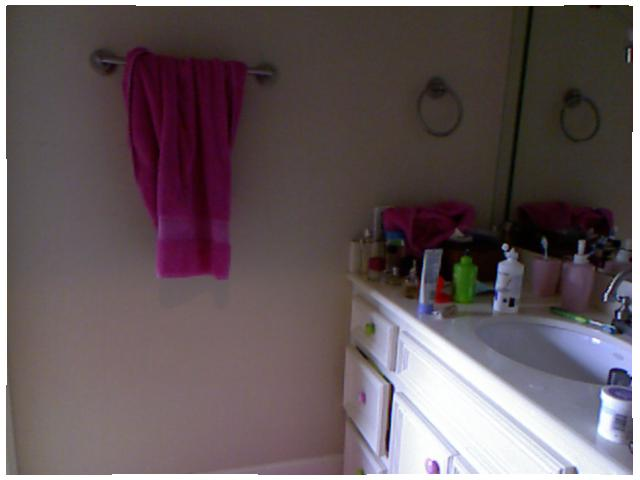

torch.Size([1, 512]) torch.Size([10, 512])


[('bedroom', 0.24831905961036682),
 ('office', 0.01511780172586441),
 ('bathroom', 0.6693894267082214),
 ('basement', 0.005297866649925709),
 ('bookstore', 2.7715519536286592e-05),
 ('dining_room', 0.0078118243254721165),
 ('classroom', 0.001059342990629375),
 ('living_room', 0.03696026653051376),
 ('cafe', 0.00018794124480336905),
 ('kitchen', 0.015828851610422134)]

In [4]:
# Load and display an RGB image from the bathroom class
img = Image.open("depth_images/bathroom/train/22.jpg")
display(img)

# Process the image and text labels through CLIP
# Creates text prompts like "a photo of a bedroom", "a photo of an office", etc.
# Returns tensors for both the image and text embeddings
inputs = clip_processor(text=[f"a photo of a {label}" for label in labels], images=img, return_tensors="pt", padding=True)

# Run the processed inputs through the CLIP model
outputs = clip_model(**inputs)

# Print the shapes of the image and text embeddings to verify dimensions
print(outputs.image_embeds.shape, outputs.text_embeds.shape)

# Get prediction scores for each class:
# 1. outputs.logits_per_image gives raw logits
# 2. softmax converts logits to probabilities
# 3. detach removes gradient tracking
# 4. numpy converts to numpy array
# 5. squeeze removes extra dimensions
# 6. zip pairs class labels with their probabilities
list(zip(labels, outputs.logits_per_image.softmax(dim=1).detach().numpy().squeeze().tolist()))

* As you can see, the label is correct (top-1 is bathroom) but the confidence is low (0.66)
* Let us try a depth image

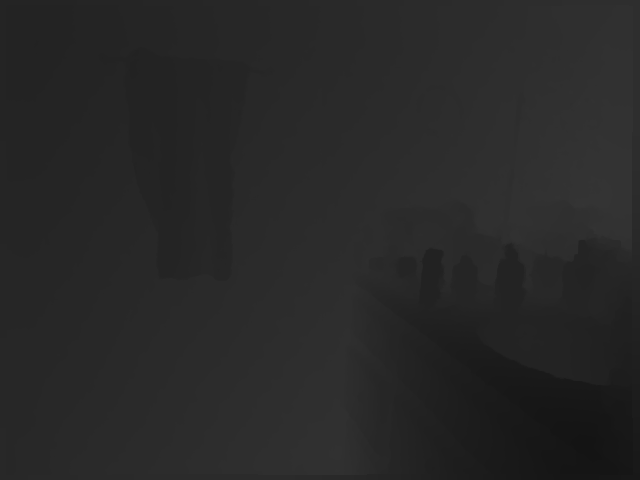

[('bedroom', 0.057066429406404495),
 ('office', 0.02027421072125435),
 ('bathroom', 0.060860440135002136),
 ('basement', 0.36595749855041504),
 ('bookstore', 0.0027488290797919035),
 ('dining_room', 0.18828754127025604),
 ('classroom', 0.029672211036086082),
 ('living_room', 0.2123427838087082),
 ('cafe', 0.010856329463422298),
 ('kitchen', 0.05193381384015083)]

In [5]:
img = Image.open("depth_images/bathroom/train/22.png")
display(img)
inputs = clip_processor(text=[f"a photo of a {label}" for label in labels], images=img, return_tensors="pt", padding=True)
outputs = clip_model(**inputs)
list(zip(labels, outputs.logits_per_image.softmax(dim=1).detach().numpy().squeeze().tolist()))

### Looks like the model does not work on this image on depth map, top-1 is basement (0.36)
### Let us calculate accuracy on the entire train/test sets

In [6]:
def score(imgs):
    total = 0.
    for img in imgs:
        PIL_img = Image.open(img)
        inputs = clip_processor(text=[f"a photo of a {label}" for label in labels], images=PIL_img, return_tensors="pt", padding=True)
        outputs = clip_model(**inputs)
        # print(outputs.logits_per_image)
        pred = outputs.logits_per_image.argmax(dim=1).detach().numpy().squeeze().item()
        total += 1. if (labels[pred] in img) else 0.
        # print(labels, img, labels[pred])
        # list(zip(labels, outputs.logits_per_image.softmax(dim=1).detach().numpy().squeeze().tolist()))
    return total / len(imgs)

In [8]:
print('RGB train set accuracy', score(glob("depth_images/*/train/**.jpg")))
print('RGB test set accuracy', score(glob("depth_images/*/test/**.jpg")))
print('Depth train set accuracy', score(glob("depth_images/*/train/**.png")))
print('Depth test set accuracy', score(glob("depth_images/*/test/**.png")))

RGB train set accuracy 0.7652173913043478
RGB test set accuracy 0.7587719298245614
Depth train set accuracy 0.19782608695652174
Depth test set accuracy 0.18640350877192982


## Fit HD exemplars to CLIP embeddings

In [9]:
def make_LUT(nvalues, dims):
    lut = np.zeros(shape=(nvalues, dims))
    lut[0, :] = rs.binomial(n=1, p=0.5, size=(dims))
    for row in range(1, nvalues):
        lut[row, :] = lut[row-1, :]
        # flip few randomly
        rand_idx = rs.choice(dims, size=dims//nvalues, replace=False)
        lut[row, rand_idx] = 1 - lut[row, rand_idx]
        assert np.abs(lut[row, :] - lut[row-1, :]).sum() ==dims//nvalues 
    unique_rows = np.unique(lut, axis=0)
    assert len(unique_rows) == len(lut)
    return lut

In [10]:
HYPERDIMS = 4096
VALUE_BITS = 10
POS_BITS = 9 # CLIP features are 512 dims
val_bins = np.linspace(start=-1., stop=1., num=2**VALUE_BITS)
# print(val_bins.shape, val_bins.min(), val_bins.max(), 'val bins')
val_lut = make_LUT(2**VALUE_BITS, HYPERDIMS)
assert val_lut.shape[0] == val_bins.shape[0]
pos_lut = rs.binomial(n=1, p=0.5, size=(2**POS_BITS, HYPERDIMS))

In [11]:
def extract_features(fname):
    PIL_image = Image.open(fname)
    inputs = clip_processor(text=[f"a photo of a {lab}" for lab in labels], images=PIL_image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    # print(outputs.image_embeds.shape)
    return outputs.image_embeds.detach().numpy().squeeze(), outputs.text_embeds.detach().numpy().squeeze()

In [12]:
def quantize_embeds(embeds):
    assert np.all(embeds >= val_bins[0])
    assert np.all(embeds <= val_bins[-1])
    embeds_flat = embeds.flatten()

    all_pairs_dist = np.abs(embeds_flat[:, np.newaxis] - val_bins[np.newaxis, :])
    closest_bin = np.argmin(all_pairs_dist, axis=-1)
    quantized_embeds_flat = val_bins[closest_bin]
    quantized_embeds = np.reshape(quantized_embeds_flat, embeds.shape)
    closest_bin = np.reshape(closest_bin, embeds.shape)
    # print(closest_bin.shape, 'values are in bins', closest_bin.min(), 'to', closest_bin.max())
    # print('abs quant error avg', np.abs(embeds - quantized_embeds).mean())
    return quantized_embeds, closest_bin

In [13]:
def encode(fname):
    embed_image, embed_text = extract_features(fname)

    quantized_embeds, closest_bin = quantize_embeds(embed_image)
    hd_image_per_pos = val_lut[closest_bin]
    quantized_embeds, closest_bin = quantize_embeds(embed_text)
    hd_text_per_pos = val_lut[closest_bin]

    # bind image and text per pos
    xor = lambda a,b: a*(1.-b) + b*(1.-a)
    hd_image = xor(hd_image_per_pos, pos_lut)
    # bundle along pos dimension 512
    hd_image = np.sum(hd_image, axis=0) / 512
    hd_image[hd_image >= .5] = 1.
    hd_image[hd_image < .5] = 0.
     
    hd_text = xor(hd_text_per_pos, pos_lut[np.newaxis, ...])
    # bundle along pos dimension 512
    hd_text = np.sum(hd_text, axis=1) / 512
    hd_text[hd_text >= .5] = 1.
    hd_text[hd_text < .5] = 0.

    hd_encoded = xor(hd_image[np.newaxis, ...], hd_text)
    return hd_encoded

In [14]:
def update_exemplars(fname, exemplars_integer, counts):
    hd_encoded = encode(fname)
    label = fname.split(os.path.sep)[-3]
    # print(labels, labels.shape)
    assert label in labels
    idx = labels.index(label)
    exemplars_integer[label] += hd_encoded[idx,...]
    counts[label] += 1

In [15]:
def threshold_exemplar(exemplars_integer, counts):
    exemplars = {}
    for lab in labels:
        exemplars[lab] = (exemplars_integer[lab] / counts[lab]) if counts[lab] > 0 else exemplars_integer[lab]
        exemplars[lab][exemplars[lab] >= 0.5] = 1.
        exemplars[lab][exemplars[lab] < 0.5] = 0.
    return exemplars

In [16]:
def score_hd(fname, exemplars_integer, counts):
    hd_encoded = encode(fname)
    label = fname.split(os.path.sep)[-3]
    # print(labels, labels.shape)
    assert label in labels

    exemplars = threshold_exemplar(exemplars_integer, counts)
    dist_to_exemplars = {lab: np.abs(exemplars[lab]-hd_encoded[idx]).sum() for idx, lab in enumerate(labels)}
    # print(dist_to_exemplars)
    pred = [lab for lab in labels if dist_to_exemplars[lab] == min(dist_to_exemplars.values())][0]
    # print(pred, label)
    return 1. if pred == label else 0., pred

In [17]:
def eval(images, exemplars_integer, counts):
    return sum([score_hd(fname, exemplars_integer, counts)[0] for fname in images]) / len(images)

## HD accuracy before training

In [18]:
exemplars_integer = {lab: np.zeros(HYPERDIMS) for lab in labels}
counts = {lab: 0. for lab in labels}
print('[HD - before training] RGB train acc', eval(glob("depth_images/*/train/**.jpg"), exemplars_integer, counts))
print('[HD - before training] RGB test acc', eval(glob("depth_images/*/test/**.jpg"), exemplars_integer, counts))
print('[HD - before training] Depth train acc', eval(glob("depth_images/*/train/**.png"), exemplars_integer, counts))
print('[HD - before training] Depth test acc', eval(glob("depth_images/*/test/**.png"), exemplars_integer, counts))

[HD - before training] RGB train acc 0.18695652173913044
[HD - before training] RGB test acc 0.20394736842105263
[HD - before training] Depth train acc 0.11521739130434783
[HD - before training] Depth test acc 0.1074561403508772


## Train on RGB using HD

In [19]:
exemplars_integer = {lab: np.zeros(HYPERDIMS) for lab in labels}
counts = {lab: 0. for lab in labels}
for fname in glob("depth_images/*/train/**.jpg"):
    update_exemplars(fname, exemplars_integer, counts)    
print(exemplars_integer)
print('[HD - after rgb training] RGB train acc', eval(glob("depth_images/*/train/**.jpg"), exemplars_integer, counts))
print('[HD - after rgb training] RGB test acc', eval(glob("depth_images/*/test/**.jpg"), exemplars_integer, counts))
print('[HD - after rgb training] Depth train acc', eval(glob("depth_images/*/train/**.png"), exemplars_integer, counts))
print('[HD - after rgb training] Depth test acc', eval(glob("depth_images/*/test/**.png"), exemplars_integer, counts))


{'bedroom': array([0., 0., 0., ..., 0., 0., 0.]), 'office': array([0., 0., 0., ..., 0., 0., 0.]), 'bathroom': array([0., 0., 0., ..., 0., 0., 0.]), 'basement': array([0., 0., 1., ..., 0., 0., 0.]), 'bookstore': array([0., 0., 0., ..., 0., 0., 0.]), 'dining_room': array([0., 0., 0., ..., 0., 0., 0.]), 'classroom': array([0., 0., 1., ..., 0., 0., 0.]), 'living_room': array([0., 0., 0., ..., 0., 0., 0.]), 'cafe': array([0., 0., 0., ..., 0., 0., 0.]), 'kitchen': array([0., 0., 3., ..., 0., 0., 0.])}
[HD - after rgb training] RGB train acc 0.8260869565217391
[HD - after rgb training] RGB test acc 0.7149122807017544
[HD - after rgb training] Depth train acc 0.1108695652173913
[HD - after rgb training] Depth test acc 0.07236842105263158


## Train on depth

In [20]:
exemplars_integer = {lab: np.zeros(HYPERDIMS) for lab in labels}
counts = {lab: 0. for lab in labels}
for fname in glob("depth_images/*/train/**.png"):
    update_exemplars(fname, exemplars_integer, counts)    
print(exemplars_integer)
print('[HD - after depth training] RGB train acc', eval(glob("depth_images/*/train/**.jpg"), exemplars_integer, counts))
print('[HD - after depth training] RGB test acc', eval(glob("depth_images/*/test/**.jpg"), exemplars_integer, counts))
print('[HD - after depth training] Depth train acc', eval(glob("depth_images/*/train/**.png"), exemplars_integer, counts))
print('[HD - after depth training] Depth test acc', eval(glob("depth_images/*/test/**.png"), exemplars_integer, counts))


{'bedroom': array([0., 0., 0., ..., 0., 0., 0.]), 'office': array([0., 0., 0., ..., 0., 0., 0.]), 'bathroom': array([0., 0., 0., ..., 0., 0., 0.]), 'basement': array([0., 0., 0., ..., 0., 0., 0.]), 'bookstore': array([0., 0., 0., ..., 0., 0., 0.]), 'dining_room': array([0., 0., 1., ..., 0., 0., 0.]), 'classroom': array([0., 0., 0., ..., 0., 0., 0.]), 'living_room': array([0., 0., 0., ..., 0., 0., 0.]), 'cafe': array([0., 0., 0., ..., 0., 0., 0.]), 'kitchen': array([0., 0., 0., ..., 0., 0., 0.])}
[HD - after depth training] RGB train acc 0.14347826086956522
[HD - after depth training] RGB test acc 0.12719298245614036
[HD - after depth training] Depth train acc 0.3782608695652174
[HD - after depth training] Depth test acc 0.31140350877192985


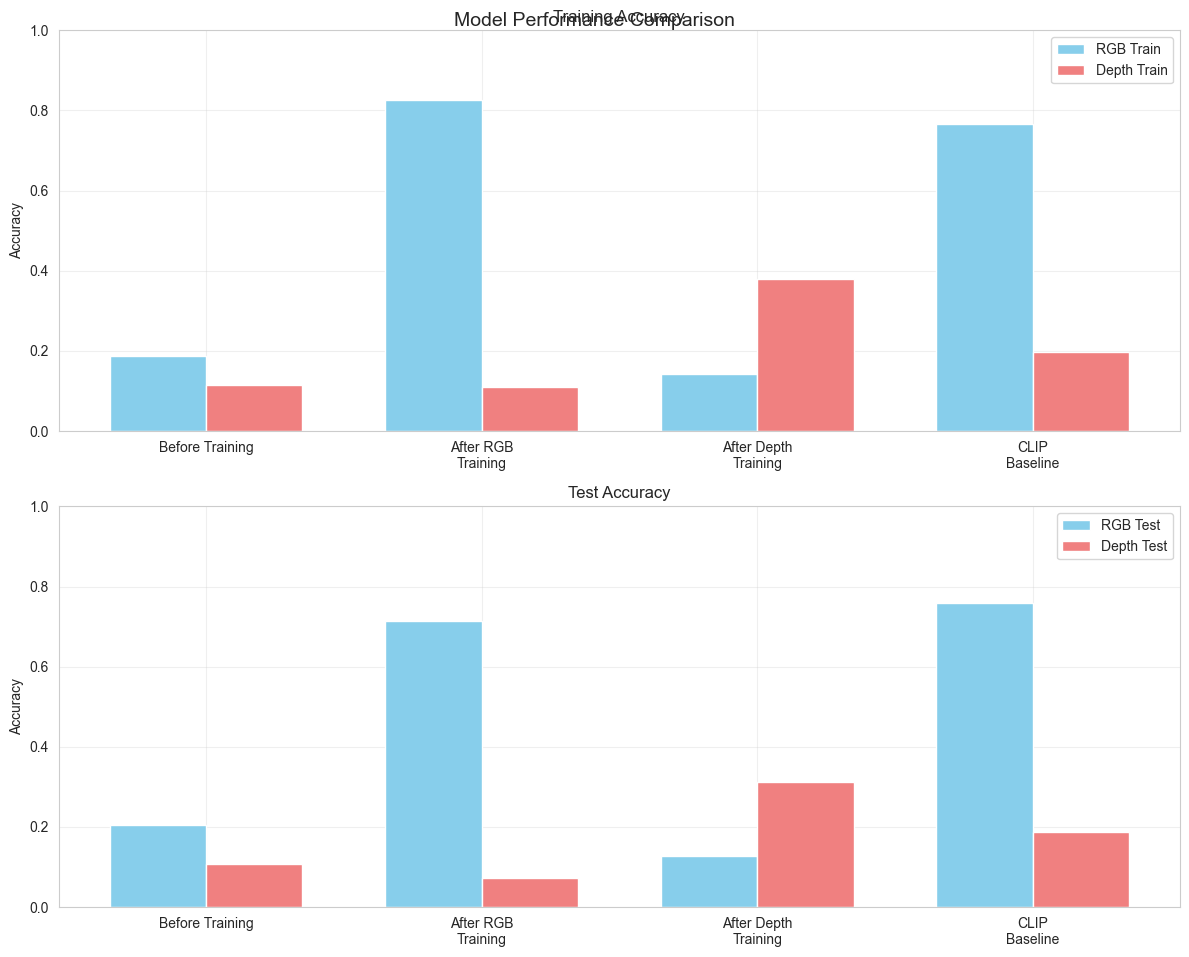

In [22]:
# Visualize results of HD training 
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
rgb_data = {
    'Before Training': [0.18695652173913044, 0.20394736842105263],  # train, test
    'After RGB Training': [0.8260869565217391, 0.7149122807017544],
    'After Depth Training': [0.14347826086956522, 0.12719298245614036],
    'CLIP Baseline': [0.7652173913043478, 0.7587719298245614]
}

depth_data = {
    'Before Training': [0.11521739130434783, 0.1074561403508772],
    'After RGB Training': [0.1108695652173913, 0.07236842105263158],
    'After Depth Training': [0.3782608695652174, 0.31140350877192985],
    'CLIP Baseline': [0.19782608695652174, 0.18640350877192982]
}

# Create figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 1])
fig.suptitle('Model Performance Comparison', fontsize=14, y=0.95)

# Set width of bars and positions
barWidth = 0.35
r1 = np.arange(len(rgb_data))
r2 = [x + barWidth for x in r1]

# Create bars for training accuracies
ax1.bar(r1, [rgb_data[k][0] for k in rgb_data.keys()], barWidth, label='RGB Train', color='skyblue')
ax1.bar(r2, [depth_data[k][0] for k in depth_data.keys()], barWidth, label='Depth Train', color='lightcoral')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training Accuracy')
ax1.set_xticks([r + barWidth/2 for r in range(len(rgb_data))],
               ['Before Training', 'After RGB\nTraining', 'After Depth\nTraining', 'CLIP\nBaseline'])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.0)

# Create bars for test accuracies
ax2.bar(r1, [rgb_data[k][1] for k in rgb_data.keys()], barWidth, label='RGB Test', color='skyblue')
ax2.bar(r2, [depth_data[k][1] for k in depth_data.keys()], barWidth, label='Depth Test', color='lightcoral')
ax2.set_ylabel('Accuracy')
ax2.set_title('Test Accuracy')
ax2.set_xticks([r + barWidth/2 for r in range(len(rgb_data))],
               ['Before Training', 'After RGB\nTraining', 'After Depth\nTraining', 'CLIP\nBaseline'])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()
